## 导入依赖

In [1]:
import sys
import os
import numpy as np
import cv2
import open3d as o3d
from matplotlib import pyplot as plt
import yaml
import logging

# 导入阿凯写的Orbbec工具库, 确保orbbec_utils.py跟你目前所执行的脚本在同一级目录下
from orbbecsdk_utils import *
# 将pyorbbecsdk的动态链接库所在的文件夹，添加到Python Path
add_path_pyorbbecsdk()
# 导入pyorbbecsdk
from pyorbbecsdk import *

logging.basicConfig(level=logging.ERROR)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## 视频流初始化

In [2]:
# 连接设备
ret, device = connect_device()
print(f"[INFO] 设备是否连接成功: {ret}")

INFO:OrbbecSDK Utils:[INFO] 检测到1个设备
INFO:OrbbecSDK Utils:[INFO]设备序列号为: CP1L44P00049
INFO:OrbbecSDK Utils:[INFO]重新刷新设备列表
INFO:OrbbecSDK Utils:[INFO]设备成功创建连接


[INFO] 设备是否连接成功: True


## 加载配置文件

In [3]:
# 载入Gemini2相机的配置文件
with open(os.path.join(".", "gemini335.yaml"), 'r', encoding='utf-8') as f:
    camera_config_yaml = yaml.load(f.read(), Loader=yaml.SafeLoader)

print("加载到的YAML配置文件: ")
print(camera_config_yaml)

加载到的YAML配置文件: 
{'rgb_camera': {'auto_exposure': True, 'exposure': 10000, 'gain': 101, 'brightness': 52, 'auto_white_balance': True, 'white_balance': 5000, 'sharpness': 99, 'saturation': 32, 'contrast': 40, 'power_line_frequency': 0}, 'depth_camera': {'auto_exposure': True, 'exposure': 3000, 'gain': 1000, 'depth_work_mode': 2}}


## 配置相机

In [4]:
rgb_config = camera_config_yaml['rgb_camera']
logger.info("[彩色相机配置]")

# 配置曝光与相关参数
if rgb_config['auto_exposure']:
    # 自动曝光
    logger.info(f"- 打开自动曝光")
    device.set_bool_property(OBPropertyID.OB_PROP_COLOR_AUTO_EXPOSURE_BOOL, True)
    # 设置亮度
    logger.info(f"- 亮度: {rgb_config['brightness']}")
    # 设置相机亮度
    device.set_int_property(OBPropertyID.OB_PROP_COLOR_BRIGHTNESS_INT, rgb_config['brightness'])
else:
    # 关闭自动曝光
    logger.info(f"- 关闭自动曝光")
    device.set_bool_property(OBPropertyID.OB_PROP_COLOR_AUTO_EXPOSURE_BOOL, False)
    # 设置曝光值
    logger.info(f"- 曝光: {rgb_config['exposure']}")
    device.set_int_property(OBPropertyID.OB_PROP_COLOR_EXPOSURE_INT, rgb_config['exposure'])
    # 设置增益
    logger.info(f"- 增益: {rgb_config['gain']}")
    device.set_int_property(OBPropertyID.OB_PROP_COLOR_GAIN_INT, rgb_config['gain'])

# 配置白平衡
if rgb_config['auto_white_balance']:
    # 打开自动白平衡
    logger.info(f"- 打开自动白平衡")
    device.set_bool_property(OBPropertyID.OB_PROP_COLOR_AUTO_WHITE_BALANCE_BOOL, True)
else:
    # 关闭自动白平衡
    logger.info(f"- 关闭自动白平衡")
    device.set_bool_property(OBPropertyID.OB_PROP_COLOR_AUTO_WHITE_BALANCE_BOOL, False)
    # 设置白平衡
    logger.info(f"- 白平衡: {rgb_config['white_balance']}")
    device.set_int_property(OBPropertyID.OB_PROP_COLOR_WHITE_BALANCE_INT, rgb_config['white_balance'])

# 其他配置项
# 设置相机锐度
logger.info(f"- 锐度: {rgb_config['sharpness']}")
device.set_int_property(OBPropertyID.OB_PROP_COLOR_SHARPNESS_INT, rgb_config['sharpness'])
# 设置饱和度
logger.info(f"- 饱和度: {rgb_config['saturation']}")
device.set_int_property(OBPropertyID.OB_PROP_COLOR_SATURATION_INT, rgb_config['saturation'])
# 设置对比度
logger.info(f"- 对比度: {rgb_config['contrast']}")
device.set_int_property(OBPropertyID.OB_PROP_COLOR_CONTRAST_INT, rgb_config['contrast'])
# 电力线频率
logger.info(f"- 电力线频率: {rgb_config['power_line_frequency']}")
device.set_int_property(OBPropertyID.OB_PROP_COLOR_POWER_LINE_FREQUENCY_INT, rgb_config['power_line_frequency'])

INFO:OrbbecSDK Utils:[彩色相机配置]
INFO:OrbbecSDK Utils:- 打开自动曝光
INFO:OrbbecSDK Utils:- 亮度: 52
INFO:OrbbecSDK Utils:- 打开自动白平衡
INFO:OrbbecSDK Utils:- 锐度: 99
INFO:OrbbecSDK Utils:- 饱和度: 32
INFO:OrbbecSDK Utils:- 对比度: 40
INFO:OrbbecSDK Utils:- 电力线频率: 0


In [5]:
# 获取深度相机的配置
depth_config = camera_config_yaml['depth_camera']
logger.info("[深度相机配置]")

# 配置曝光与相关参数
if depth_config['auto_exposure']:
    logger.info(f"- 打开自动白平衡")
    device.set_bool_property(OBPropertyID.OB_PROP_DEPTH_AUTO_EXPOSURE_BOOL, True)
else:
    logger.info(f"- 关闭自动白平衡")
    device.set_bool_property(OBPropertyID.OB_PROP_DEPTH_AUTO_EXPOSURE_BOOL, False)
    logger.info(f"- 曝光: {depth_config['exposure']}")
    device.set_int_property(OBPropertyID.OB_PROP_DEPTH_EXPOSURE_INT, depth_config['exposure'])
    logger.info(f"- 增益: {depth_config['gain']}")
    device.set_int_property(OBPropertyID.OB_PROP_DEPTH_GAIN_INT, depth_config['gain'])

# # 精度等级
# logger.info(f"- 配置深度精度等级: {depth_config['precision_level']}")
# device.set_int_property(OBPropertyID.OB_PROP_DEPTH_PRECISION_LEVEL_INT, depth_config['precision_level'])

# 深度工作模式
mode_list = device.get_depth_work_mode_list()
logger.info(f"- 设置深度工作模式: {mode_list.get_name_by_index(depth_config['depth_work_mode'])}")
mode = mode_list.get_depth_work_mode_by_index(depth_config['depth_work_mode'])
device.set_depth_work_mode(mode)


INFO:OrbbecSDK Utils:[深度相机配置]
INFO:OrbbecSDK Utils:- 打开自动白平衡
INFO:OrbbecSDK Utils:- 设置深度工作模式: High Accuracy


<OBStatus.STATUS_OK: 0>

In [6]:
# pipeline初始化
pipeline = init_pipeline(device)
# 清空缓冲区
empty_cache(pipeline)

# 获取pipeline的相机参数
camera_param = pipeline.get_camera_param()

INFO:OrbbecSDK Utils:[INFO] 数据帧读取成功
INFO:OrbbecSDK Utils:[INFO] 数据帧读取成功
INFO:OrbbecSDK Utils:[INFO] 数据帧读取成功
INFO:OrbbecSDK Utils:[INFO] 数据帧读取成功
INFO:OrbbecSDK Utils:[INFO] 数据帧读取成功
INFO:OrbbecSDK Utils:[INFO] 数据帧读取成功
INFO:OrbbecSDK Utils:[INFO] 数据帧读取成功
INFO:OrbbecSDK Utils:[INFO] 数据帧读取成功
INFO:OrbbecSDK Utils:[INFO] 数据帧读取成功
INFO:OrbbecSDK Utils:[INFO] 数据帧读取成功
INFO:OrbbecSDK Utils:[INFO] 彩图获取成功
INFO:OrbbecSDK Utils:[INFO] 深度图获取成功
INFO:OrbbecSDK Utils:[INFO] 数据帧读取成功
INFO:OrbbecSDK Utils:[INFO] 彩图获取成功
INFO:OrbbecSDK Utils:[INFO] 深度图获取成功
INFO:OrbbecSDK Utils:[INFO] 数据帧读取成功
INFO:OrbbecSDK Utils:[INFO] 彩图获取成功
INFO:OrbbecSDK Utils:[INFO] 深度图获取成功
INFO:OrbbecSDK Utils:[INFO] 数据帧读取成功
INFO:OrbbecSDK Utils:[INFO] 彩图获取成功
INFO:OrbbecSDK Utils:[INFO] 深度图获取成功
INFO:OrbbecSDK Utils:[INFO] 数据帧读取成功
INFO:OrbbecSDK Utils:[INFO] 彩图获取成功
INFO:OrbbecSDK Utils:[INFO] 深度图获取成功
INFO:OrbbecSDK Utils:[INFO] 数据帧读取成功
INFO:OrbbecSDK Utils:[INFO] 数据帧读取成功
INFO:OrbbecSDK Utils:[INFO] 彩图获取成功
INFO:OrbbecSDK Utils:[INFO] 深度图获取成

## 预览图像

In [7]:
# 重新调整日志等级为WARN
logger.setLevel(logging.WARN)

In [10]:
# 多采集几次, 清除缓存让配置生效
for i in range(30):
    ret, color_img, depth_img = capture(pipeline)    

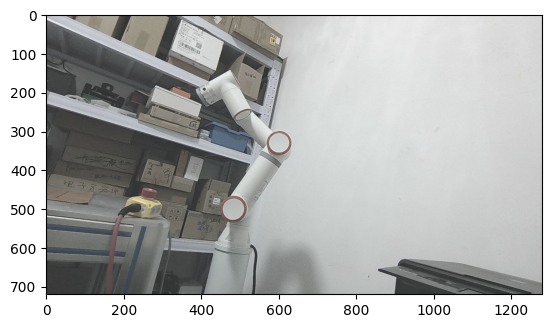

In [11]:
plt.imshow(color_img[:, :, ::-1])

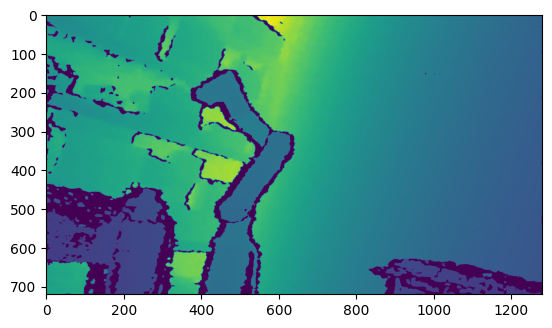

In [12]:
plt.imshow(depth_img)